In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# XGBoost (opcional)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

In [2]:
WINDOW_SIZE = 5          # retrospecto recente por time
H2H_WINDOW = 5           # confronto direto (últimos N jogos entre eles)
RETA_FINAL_TH = 0.75     # >= 75% do campeonato

In [3]:
print("Carregando dados...")
df_full = pd.read_csv('/Users/rodrigokauer/Desktop/tcc/dataset/campeonato-brasileiro-full.csv')
df_stats = pd.read_csv('/Users/rodrigokauer/Desktop/tcc/dataset/campeonato-brasileiro-estatisticas-full.csv')

df_full['data'] = pd.to_datetime(df_full['data'], dayfirst=True)

def clean_percent(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        return float(x.replace('%', ''))
    return x

df_stats['posse_de_bola'] = df_stats['posse_de_bola'].apply(clean_percent)
df_stats['precisao_passes'] = df_stats['precisao_passes'].apply(clean_percent)

stats_cols = ['chutes', 'chutes_no_alvo', 'posse_de_bola', 'passes', 'precisao_passes', 'escanteios', 'faltas']

# zeros como NaN (para não confundir "0 real" vs "faltou dado")
for col in stats_cols:
    df_stats[col] = df_stats[col].replace(0, np.nan)

cols_match = ['ID', 'data', 'mandante', 'visitante', 'mandante_Placar', 'visitante_Placar']
df_partidas = df_full[cols_match].copy()

# target: 2=mandante vence, 1=empate, 0=visitante vence
condicoes = [
    df_partidas['mandante_Placar'] > df_partidas['visitante_Placar'],
    df_partidas['mandante_Placar'] == df_partidas['visitante_Placar'],
    df_partidas['mandante_Placar'] < df_partidas['visitante_Placar']
]
df_partidas['target'] = np.select(condicoes, [2, 1, 0])

df_partidas = df_partidas.sort_values('data').reset_index(drop=True)

Carregando dados...


In [ ]:
# momento do camp
df_partidas['ano'] = df_partidas['data'].dt.year
df_partidas['rodada'] = df_partidas.groupby('ano').cumcount() + 1
df_partidas['rodadas_no_ano'] = df_partidas.groupby('ano')['rodada'].transform('max')
df_partidas['fase_campeonato'] = df_partidas['rodada'] / df_partidas['rodadas_no_ano']
df_partidas['reta_final'] = (df_partidas['fase_campeonato'] >= RETA_FINAL_TH).astype(int)

# confronto reg
TEAM_STATE = {
    # RJ
    'Flamengo': 'RJ', 'Fluminense': 'RJ', 'Vasco': 'RJ', 'Botafogo': 'RJ',
    # SP
    'Palmeiras': 'SP', 'Corinthians': 'SP', 'São Paulo': 'SP', 'Santos': 'SP',
    # MG
    'Atlético-MG': 'MG', 'Cruzeiro': 'MG',
    # RS
    'Grêmio': 'RS', 'Internacional': 'RS',
    # PR
    'Athletico-PR': 'PR', 'Coritiba': 'PR',
    # BA
    'Bahia': 'BA', 'Vitória': 'BA',
    # SC
    'Figueirense': 'SC', 'Avaí': 'SC',
    # CE
    'Ceará': 'CE', 'Fortaleza': 'CE',
    # PE
    'Sport': 'PE', 'Náutico': 'PE', 'Santa Cruz': 'PE',
    # GO
    'Goiás': 'GO', 'Atlético-GO': 'GO',
}

df_partidas['uf_mandante'] = df_partidas['mandante'].map(TEAM_STATE)
df_partidas['uf_visitante'] = df_partidas['visitante'].map(TEAM_STATE)
df_partidas['confronto_regional'] = (df_partidas['uf_mandante'] == df_partidas['uf_visitante']).astype(float)


# confronto direto 
print("Calculando features de confronto direto (H2H)...")
df_h2h_base = df_partidas[['data', 'mandante', 'visitante', 'mandante_Placar', 'visitante_Placar']].copy()

def h2h_features(row, window=H2H_WINDOW):
    a = row['mandante']
    b = row['visitante']
    dt = row['data']

    mask = (
        (((df_h2h_base['mandante'] == a) & (df_h2h_base['visitante'] == b)) |
         ((df_h2h_base['mandante'] == b) & (df_h2h_base['visitante'] == a)))
        & (df_h2h_base['data'] < dt)
    )

    hist = df_h2h_base.loc[mask].sort_values('data').tail(window)

    if hist.empty:
        return pd.Series({
            'h2h_jogos_ult_n': 0,
            'h2h_vitorias_mandante_ult_n': 0,
            'h2h_vitorias_visitante_ult_n': 0,
            'h2h_empates_ult_n': 0,
            'h2h_saldo_gols_mandante_ult_n': 0
        })

    h2h_win_home = 0
    h2h_win_away = 0
    h2h_draws = 0
    saldo = 0

    for _, r in hist.iterrows():
        # gols do A e do B naquela partida (A=mandante atual, B=visitante atual)
        if r['mandante'] == a and r['visitante'] == b:
            gols_a = r['mandante_Placar']
            gols_b = r['visitante_Placar']
        elif r['mandante'] == b and r['visitante'] == a:
            gols_a = r['visitante_Placar']
            gols_b = r['mandante_Placar']
        else:
            continue

        saldo += (gols_a - gols_b)

        if gols_a > gols_b:
            h2h_win_home += 1
        elif gols_a < gols_b:
            h2h_win_away += 1
        else:
            h2h_draws += 1

    return pd.Series({
        'h2h_jogos_ult_n': len(hist),
        'h2h_vitorias_mandante_ult_n': h2h_win_home,
        'h2h_vitorias_visitante_ult_n': h2h_win_away,
        'h2h_empates_ult_n': h2h_draws,
        'h2h_saldo_gols_mandante_ult_n': saldo
    })

h2h_df = df_partidas.apply(h2h_features, axis=1)
df_partidas = pd.concat([df_partidas, h2h_df], axis=1)

Calculando features de confronto direto (H2H)...


In [ ]:
print("Gerando dataset por time (mandante/visitante) + rolling...")

def prepare_team_stats(df, is_home):
    team_col = 'mandante' if is_home else 'visitante'
    opp_col = 'visitante' if is_home else 'mandante'
    goals_pro = 'mandante_Placar' if is_home else 'visitante_Placar'
    goals_con = 'visitante_Placar' if is_home else 'mandante_Placar'

    cols = ['ID', 'data', team_col, opp_col, goals_pro, goals_con, 'target', 'ano']
    df_team = df[cols].copy()
    df_team.rename(columns={
        team_col: 'time',
        opp_col: 'oponente',
        goals_pro: 'gols_pro',
        goals_con: 'gols_sofridos'
    }, inplace=True)

    # pontos do ponto de vista do time
    if is_home:
        df_team['pontos'] = np.where(df_team['target'] == 2, 3, np.where(df_team['target'] == 1, 1, 0))
    else:
        df_team['pontos'] = np.where(df_team['target'] == 0, 3, np.where(df_team['target'] == 1, 1, 0))

    # W/D/L e forma
    df_team['win'] = (df_team['pontos'] == 3).astype(int)
    df_team['draw'] = (df_team['pontos'] == 1).astype(int)
    df_team['loss'] = (df_team['pontos'] == 0).astype(int)

    # forma: +1 vitória, 0 empate, -1 derrota
    df_team['forma1'] = np.select(
        [df_team['win'] == 1, df_team['draw'] == 1, df_team['loss'] == 1],
        [1, 0, -1],
        default=0
    )

    df_team['is_home'] = int(is_home)
    return df_team

home = prepare_team_stats(df_partidas, is_home=True)
away = prepare_team_stats(df_partidas, is_home=False)

df_team_matches = pd.concat([home, away]).sort_values(['time', 'data']).reset_index(drop=True)

# merge stats do jogo (por time)
df_team_matches = df_team_matches.merge(
    df_stats[['partida_id', 'clube'] + stats_cols],
    left_on=['ID', 'time'],
    right_on=['partida_id', 'clube'],
    how='left'
)

# rolling geral por time (últimos WINDOW_SIZE) com shift(1) para evitar vazamento
features_to_roll = ['gols_pro', 'gols_sofridos', 'pontos'] + stats_cols + ['win', 'draw', 'loss', 'forma1']

grouped = df_team_matches.groupby('time')
rolling_stats = grouped[features_to_roll].apply(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean().shift(1)
).reset_index(level=0, drop=True)

new_cols = [f'media_{col}_ult_{WINDOW_SIZE}' for col in features_to_roll]
rolling_stats.columns = new_cols
df_team_features = pd.concat([df_team_matches, rolling_stats], axis=1)

# rolling específico por CASA/FORA (mandante vs visitante)
grouped_side = df_team_features.groupby(['time', 'is_home'])
side_roll = grouped_side[features_to_roll].apply(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean().shift(1)
).reset_index(level=[0, 1], drop=True)

side_cols = [f'media_side_{col}_ult_{WINDOW_SIZE}' for col in features_to_roll]
side_roll.columns = side_cols
df_team_features = pd.concat([df_team_features, side_roll], axis=1)

cols_to_keep = ['ID', 'time', 'is_home'] + new_cols + side_cols
df_features_final = df_team_features[cols_to_keep].copy()

Gerando dataset por time (mandante/visitante) + rolling...


In [6]:
print("Montando df_final com features home/away + partida...")

df_final = df_partidas.merge(
    df_features_final,
    left_on=['ID', 'mandante'],
    right_on=['ID', 'time'],
    how='left'
).drop(columns=['time'])

rename_home = {c: f'home_{c}' for c in (new_cols + side_cols)}
df_final.rename(columns=rename_home, inplace=True)

df_final = df_final.merge(
    df_features_final,
    left_on=['ID', 'visitante'],
    right_on=['ID', 'time'],
    how='left',
    suffixes=('', '_tmp')
).drop(columns=['time'])

rename_away = {c: f'away_{c}' for c in (new_cols + side_cols)}
df_final.rename(columns=rename_away, inplace=True)

df_final.drop(columns=['uf_mandante', 'uf_visitante'], inplace=True, errors='ignore')

Montando df_final com features home/away + partida...


In [ ]:
print("\nPreparando modelagem MULTICLASSE (3 classes)...")

df_model = df_final.sort_values('data').copy()

# encoding times
le = LabelEncoder()
all_teams = pd.concat([df_model['mandante'], df_model['visitante']]).unique()
le.fit(all_teams)

df_model['mandante_code'] = le.transform(df_model['mandante'])
df_model['visitante_code'] = le.transform(df_model['visitante'])

# Features
feature_cols = (
    ['mandante_code', 'visitante_code',
     'rodada', 'fase_campeonato', 'reta_final', 'confronto_regional',
     'h2h_jogos_ult_n', 'h2h_vitorias_mandante_ult_n', 'h2h_vitorias_visitante_ult_n',
     'h2h_empates_ult_n', 'h2h_saldo_gols_mandante_ult_n']
    +
    [c for c in df_model.columns if c.startswith('home_media_') or c.startswith('away_media_')
     or c.startswith('home_media_side_') or c.startswith('away_media_side_')]
)

X = df_model[feature_cols]
y = df_model['target']  # 0, 1, 2

# Split temporal 80/20
split_idx = int(len(X) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("\nDistribuição de classes:")
print("Treino:\n", y_train.value_counts().sort_index())
print("Teste:\n", y_test.value_counts().sort_index())

if y_train.nunique() < 3:
    print("\n[AVISO] y_train não tem as 3 classes. Alguns modelos ainda treinam, mas o resultado pode ficar ruim.")

# Modelos (multiclasse)
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, multi_class='auto'),
    'Random Forest': RandomForestClassifier(n_estimators=400, max_depth=12, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=800, random_state=42)
}

if xgb_available:
    # XGBoost para MULTICLASSE (3 classes)
    models['XGBoost'] = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    )

print("\nTreinando modelos (3 classes)...")
results = []
reports = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    pipeline.fit(X_train_raw, y_train)
    y_pred = pipeline.predict(X_test_raw)

    acc = accuracy_score(y_test, y_pred)

    # macro (todas classes com mesmo peso) e Weighted (ponderado pelo suporte)
    prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec_macro  = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro   = f1_score(y_test, y_pred, average='macro', zero_division=0)

    prec_w = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec_w  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_w   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        'Modelo': name,
        'Acurácia': acc,
        'Precisão (macro)': prec_macro,
        'Recall (macro)': rec_macro,
        'F1 (macro)': f1_macro,
        'Precisão (weighted)': prec_w,
        'Recall (weighted)': rec_w,
        'F1 (weighted)': f1_w
    })

    reports[name] = classification_report(
        y_test, y_pred,
        target_names=['Visitante vence (0)', 'Empate (1)', 'Mandante vence (2)'],
        zero_division=0
    )

results_df = pd.DataFrame(results).sort_values(by='F1 (weighted)', ascending=False)

print("\n=== RANKING DE MODELOS (ordenado por F1 weighted) ===")
print(results_df)

best_model_name = results_df.iloc[0]['Modelo']
print(f"\n=== CLASSIFICATION REPORT: {best_model_name} ===")
print(reports[best_model_name])



Preparando modelagem MULTICLASSE (3 classes)...

Distribuição de classes:
Treino:
 target
0    1638
1    1839
2    3551
Name: count, dtype: int64
Teste:
 target
0    466
1    483
2    808
Name: count, dtype: int64

Treinando modelos (3 classes)...
Treinando Logistic Regression...
Treinando Random Forest...


/Users/rodrigokauer/Desktop/tcc/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinando Gradient Boosting...
Treinando AdaBoost...


/Users/rodrigokauer/Desktop/tcc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Treinando Naive Bayes...
Treinando SVM...
Treinando KNN...
Treinando MLP...
Treinando XGBoost...

=== RANKING DE MODELOS (ordenado por F1 weighted) ===
                Modelo  Acurácia  Precisão (macro)  Recall (macro)  \
4          Naive Bayes  0.410928          0.381639        0.392927   
8              XGBoost  0.448492          0.382298        0.366086   
6                  KNN  0.451338          0.371589        0.365801   
0  Logistic Regression  0.468412          0.412030        0.370633   
2    Gradient Boosting  0.450768          0.381998        0.361478   
1        Random Forest  0.472965          0.423867        0.364168   
7                  MLP  0.356289          0.332470        0.331679   
5                  SVM  0.472396          0.409307        0.356463   
3             AdaBoost  0.461582          0.437993        0.342393   

   F1 (macro)  Precisão (weighted)  Recall (weighted)  F1 (weighted)  
4    0.366950             0.410838           0.410928       0.394274  
8    

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



Gerando matrizes de confusão (MULTICLASSE)...
Matriz de Confusão - Logistic Regression
[[ 67  37 362]
 [ 46  39 398]
 [ 59  32 717]]


/Users/rodrigokauer/Desktop/tcc/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


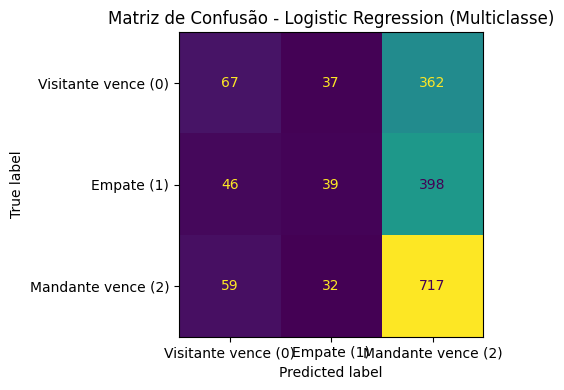

Matriz de Confusão - Random Forest
[[ 54  19 393]
 [ 33  18 432]
 [ 34  15 759]]


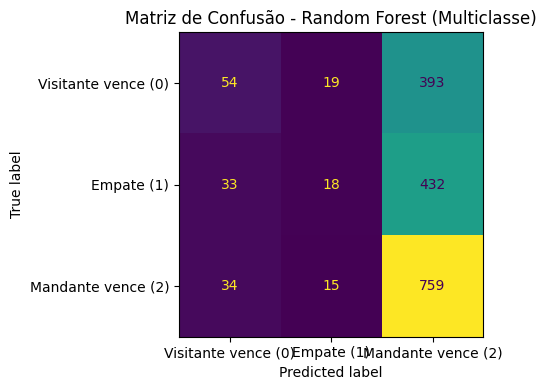

Matriz de Confusão - Gradient Boosting
[[ 68  65 333]
 [ 41  51 391]
 [ 66  69 673]]


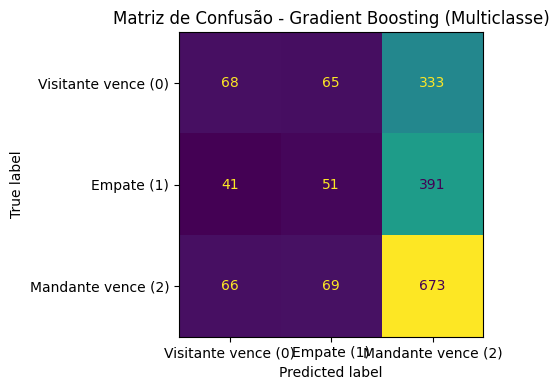

Matriz de Confusão - AdaBoost


/Users/rodrigokauer/Desktop/tcc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[[ 24   1 441]
 [ 23   2 458]
 [ 22   1 785]]


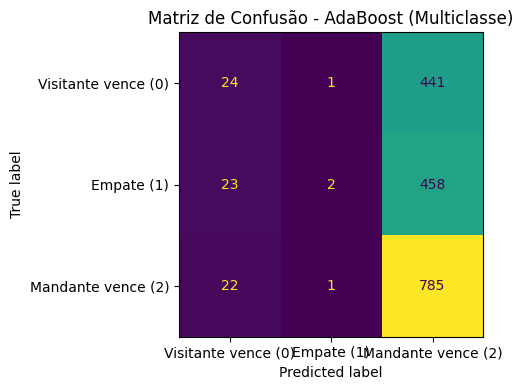

Matriz de Confusão - Naive Bayes
[[259  55 152]
 [227  60 196]
 [307  98 403]]


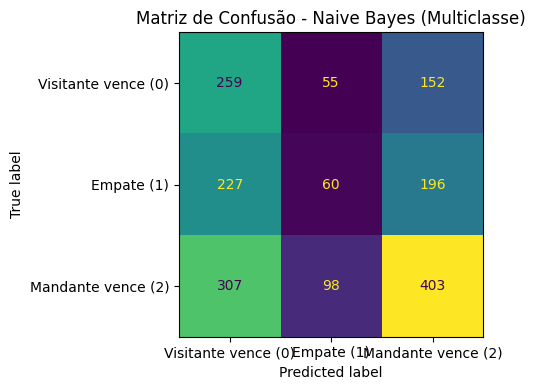

Matriz de Confusão - SVM
[[ 40   8 418]
 [ 28   7 448]
 [ 13  12 783]]


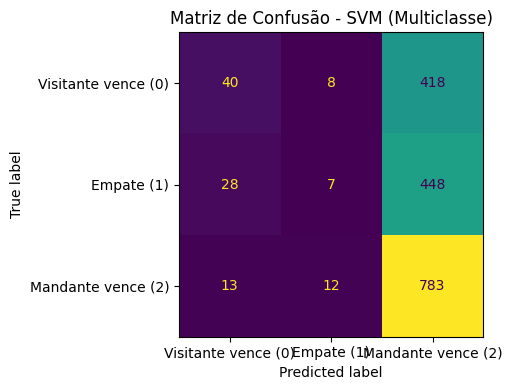

Matriz de Confusão - KNN
[[ 91  49 326]
 [ 76  40 367]
 [ 78  68 662]]


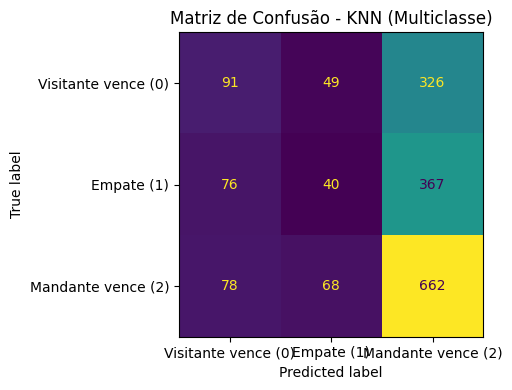

Matriz de Confusão - MLP
[[116 152 198]
 [134 138 211]
 [190 246 372]]


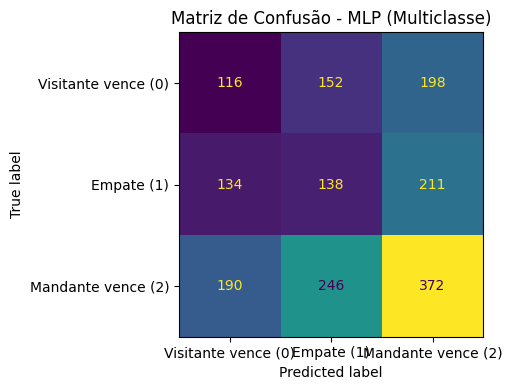

Matriz de Confusão - XGBoost
[[ 63  81 322]
 [ 47  79 357]
 [ 77  85 646]]


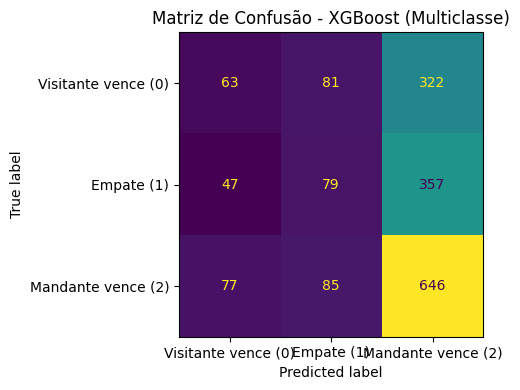

In [9]:
print("\nGerando matrizes de confusão (MULTICLASSE)...")

conf_matrices_multi = {}

for name, model in models.items():
    print(f"Matriz de Confusão - {name}")

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    pipeline.fit(X_train_raw, y_train)
    y_pred = pipeline.predict(X_test_raw)

    # matriz de confusão (contagens absolutas)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    conf_matrices_multi[name] = cm

    print(cm)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[
            'Visitante vence (0)',
            'Empate (1)',
            'Mandante vence (2)'
        ]
    )

    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap=None, colorbar=False, values_format='d')
    ax.set_title(f"Matriz de Confusão - {name} (Multiclasse)")
    plt.tight_layout()
    plt.show()
